<a href="https://colab.research.google.com/github/harperm/ADL_Natrual_Disaster/blob/main/Disaster_Images_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
import functools
import os, shutil, pathlib
import random

In [ ]:
#Mount Google Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load Data
original_dir = '/content/drive/MyDrive/Grad School/Cyclone_Wildfire_Flood_Earthquake_Database'
new_base_dir = '/content/drive/MyDrive/Grad School/Cyclone_Wildfire_Flood_Earthquake_Database/Setup'
disaster_list = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']

def make_subset(subset_name, start_index, end_index):
    for category in disaster_list:
        dir = new_base_dir + "/" + subset_name + "/" + category
        og_dir = original_dir + "/" + category
        isExist = os.path.exists(dir)
        if isExist == False:
            os.makedirs(dir)
            fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
            for fname in fnames:
                shutil.copyfile(src=og_dir + "/" + fname,
                                dst=dir + "/" + fname)
        else:
          pass

make_subset("train", start_index=0, end_index=360)
make_subset("validation", start_index=360, end_index=540)
make_subset("test", start_index=540, end_index=900)

In [ ]:
def verify_sample_size(subset_name):
    for category in disaster_list:
        print(subset_name + "/" + category + ":")
        dir = new_base_dir + "/" + subset_name + "/" + category
        print(len(os.listdir(dir)))

print('Check if samples are of same size:')
verify_sample_size("train")
verify_sample_size("validation")
verify_sample_size("test")

Check if samples are of same size:
train/Cyclone:
360
train/Earthquake:
360
train/Flood:
360
train/Wildfire:
360
validation/Cyclone:
180
validation/Earthquake:
180
validation/Flood:
180
validation/Wildfire:
180
test/Cyclone:
360
test/Earthquake:
360
test/Flood:
360
test/Wildfire:
360


In [ ]:
#Read the images
train_dataset = image_dataset_from_directory(
    new_base_dir + "/" + "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir + "/" + "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir + "/" + "test",
    image_size=(180, 180),
    batch_size=32)

Found 1440 files belonging to 4 classes.
Found 720 files belonging to 4 classes.
Found 1440 files belonging to 4 classes.


In [ ]:
#Define data augmentation layer
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  #range for random flip: 50%
        layers.RandomRotation(0.1),  #range for random rotation: +/- 10%
        layers.RandomZoom(0.2), #range for random zoom: +/- 20%
    ]
)

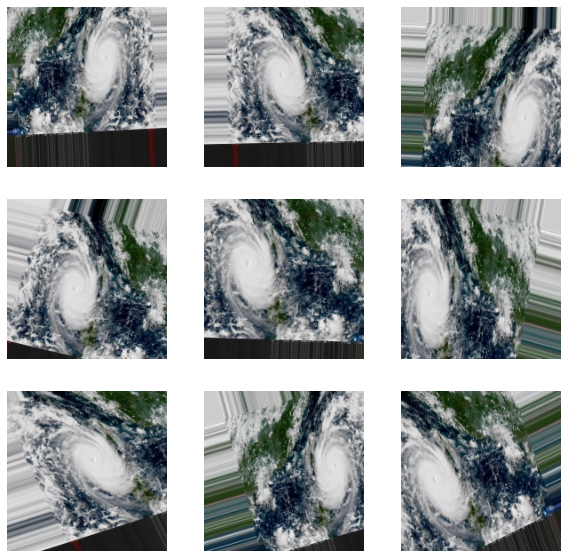

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    augmented_images = aug.flow(images)
    for i in range(9):
        # print(augmented_images[0][0].shape)
        # augmented_images = images.map(lambda x: data_augmentation(x))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0][0].astype("uint8"))
        plt.axis("off")

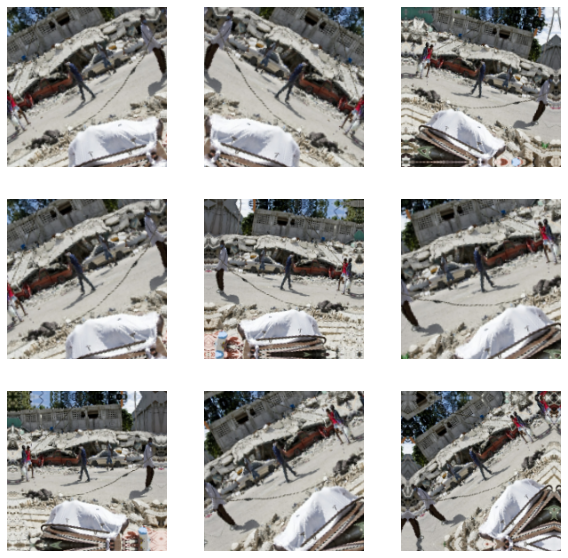

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        # augmented_images = images.map(lambda x: data_augmentation(x))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#Define CNN w/ Data aug 

model = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(32, (3, 3), activation = 'relu', input_shape= (180, 180, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation = 'relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation= 'relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation= 'relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(256, (3, 3), activation = 'relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(512, activation = 'relu'),
  layers.Dense(4, activation = 'softmax')
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
#Train model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
45/45 [==============================] - 452s 10s/step - loss: 18.8619 - accuracy: 0.3528 - val_loss: 1.1662 - val_accuracy: 0.4028
Epoch 2/100
45/45 [==============================] - 131s 3s/step - loss: 1.6377 - accuracy: 0.3444 - val_loss: 1.2027 - val_accuracy: 0.4014
Epoch 3/100
45/45 [==============================] - 131s 3s/step - loss: 1.4294 - accuracy: 0.3514 - val_loss: 1.2542 - val_accuracy: 0.3611
Epoch 4/100
45/45 [==============================] - 136s 3s/step - loss: 1.4053 - accuracy: 0.3528 - val_loss: 1.1974 - val_accuracy: 0.3958
Epoch 5/100
45/45 [==============================] - 131s 3s/step - loss: 1.3188 - accuracy: 0.4208 - val_loss: 1.5076 - val_accuracy: 0.3194
Epoch 6/100
45/45 [==============================] - 132s 3s/step - loss: 1.3119 - accuracy: 0.4451 - val_loss: 1.2367 - val_accuracy: 0.4403
Epoch 7/100
45/45 [==============================] - 133s 3s/step - loss: 1.3816 - accuracy: 0.4875 - val_loss: 1.0431 - val_accuracy: 0.4847
Epoc

In [ ]:
#Accuracy for best model
test_generator = keras.models.load_model(
    "/content/drive/MyDrive/Grad School/Cyclone_Wildfire_Flood_Earthquake_Database/convnet_from_scratch_with_augmentation.keras")
loss_test, acc_test = test_generator.evaluate(test_dataset)
print(f"Test accuracy: {acc_test:.3f}")


45/45 [==============================] - 38s 790ms/step - loss: 0.6590 - accuracy: 0.7875
Test accuracy: 0.788


In [ ]:
test_generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 41, 41, 128)      

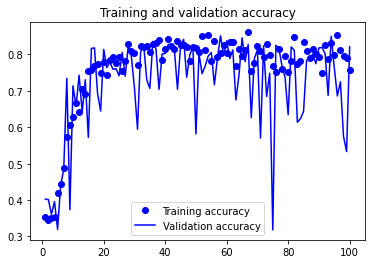

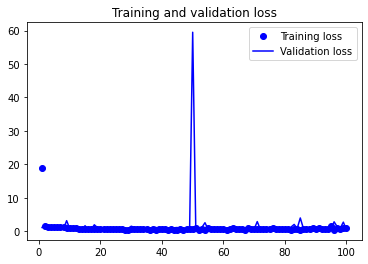

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
shutil.copyfile(src='convnet_from_scratch_with_augmentation.keras', dst='/content/drive/MyDrive/Grad School/Cyclone_Wildfire_Flood_Earthquake_Database/convnet_from_scratch_with_augmentation.keras')


'/content/drive/MyDrive/Grad School/Cyclone_Wildfire_Flood_Earthquake_Database/convnet_from_scratch_with_augmentation.keras'

In [ ]:
#Predict with best model (read in as test_generator)
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = test_generator.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
#Show images w/ Predicted Label (train data)
label_names = {0: 'cyclone', 1: 'earthquake', 2: 'flood', 3: 'wildfire'}
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[int(train_labels[i])])
        plt.axis("off")

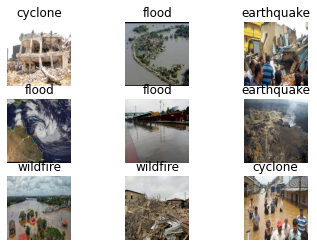

In [ ]:
#Show images w/ Predicted Label (test data)
for images, _ in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[int(test_labels[i])])
        plt.axis("off")

In [ ]:
#To do: Confusion Matrix
from sklearn.metrics import confusion_matrix
np.argmax(train_features)
predict = []

for i in range(len(train_features)):
  predict.append(np.argmax(train_features[i]))

print(len(predict))
print(len(train_labels))

matrix = confusion_matrix(predict,train_labels) #This does not seem correct :(
print(matrix)

1440
1440
[[ 89  43 137 186]
 [ 42   6  10   3]
 [  0   0   4   1]
 [229 311 209 170]]
